In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
sns.set_theme(style="white", color_codes=True, font_scale=1.5)
sns.set_palette("Set2")
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import cycle

from constrained.cube.entropic import UnitCubeEntropic
from constrained.sampling.svgd import svgd_update
from constrained.sampling.svmd import svmd_update
from constrained.sampling.kernel import imq
from constrained.target import Target
from utils import energy_dist

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
class UniformTarget(Target):
    def __init__(self):
        map = UnitCubeEntropic()
        super(UniformTarget, self).__init__(map)

    @tf.function
    def grad_logp(self, theta):
        return tf.zeros_like(theta)

    @tf.function
    def nabla_psi_inv_grad_logp(self, theta):
        return tf.zeros_like(theta)


In [3]:
K = 500
D = 2
target = UniformTarget()

2023-02-13 13:55:02.148683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 13:55:04.602004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11423 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1
2023-02-13 13:55:04.604673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11423 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
2023-02-13 13:55:04.607264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 wit

(-1.2, 1.2)

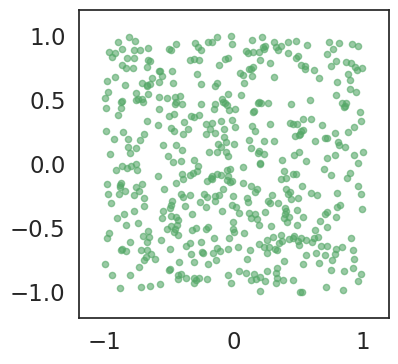

In [4]:
rng = np.random.default_rng(12345)
ground_truth_set = rng.uniform(-1., 1., size=(500, 2)).astype(np.float64)
ground_truth_set = tf.constant(ground_truth_set, dtype=tf.float64)

f, ax = plt.subplots(1, 1, figsize=(4, 4))
ground_truth_set_np = ground_truth_set.numpy()
ax.scatter(ground_truth_set_np[:, 0], ground_truth_set_np[:, 1], alpha=.6, c="g", s=20)
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])

In [5]:
def run(target, ground_truth_set, method="smvd", lr=0.005):
    rng = np.random.default_rng()
    theta0 = rng.uniform(-0.5, 0.5, (K, D)).astype(np.float64)
    theta = theta0
    eta0 = target.mirror_map.nabla_psi(theta)
    # eta: [K, D]
    eta = tf.Variable(eta0)
    n_iters = 2000
    kernel = imq
    eds = []
    trange = tqdm(range(n_iters))
    optimizer = tf.keras.optimizers.RMSprop(lr)
    for t in trange:
        if method == "svmd":
            eta_grad = svmd_update(target, theta, kernel, n_eigen_threshold=0.998, kernel_width2=0.1, eigen_gpu=True)
        elif method == "msvgd":
            eta_grad = svgd_update(target, eta, theta, kernel, kernel_width2=0.1)
        else:
            raise NotImplementedError()

        optimizer.apply_gradients([(-eta_grad, eta)])
        theta = target.mirror_map.nabla_psi_star(eta)
        if t % 20 == 0:
            ed = energy_dist(ground_truth_set, theta)
            eds.append(ed.numpy())
    return theta, eds

In [6]:
methods = ["msvgd", "svmd"]

In [7]:
samples_dict = {}
eds_dict = {}

lr_map = {
    "msvgd": 0.01,
    "svmd": 0.01,
}

for method in methods:
    theta, eds = run(target, ground_truth_set, method=method, lr=lr_map[method])
    eds_dict[method] = eds
    samples_dict[method] = theta

  0%|          | 0/2000 [00:00<?, ?it/s]2023-02-13 13:55:06.201419: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f0f4002ab70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-13 13:55:06.201472: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2023-02-13 13:55:06.201486: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
2023-02-13 13:55:06.201497: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (2): NVIDIA TITAN Xp, Compute Capability 6.1
2023-02-13 13:55:06.201507: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (3): NVIDIA TITAN Xp, Compute Capability 6.1
2023-02-13 13:55:06.564892: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


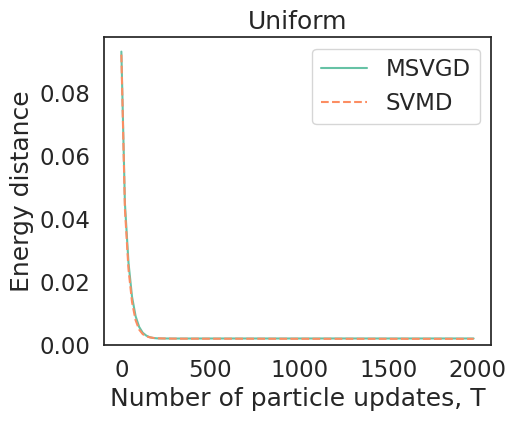

In [8]:
f, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_title("Uniform")
name_map = {
    "msvgd": "MSVGD",
    "svmd": "SVMD",
}
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

for i, method in enumerate(methods):
    linestyle = next(linecycler)
    ax.plot(np.arange(len(eds_dict[method])) * 20, eds_dict[method], linestyle, label="{}".format(name_map[method]))
ax.set_ylim(bottom=0)
ax.set_xlabel("Number of particle updates, T")
ax.set_ylabel("Energy distance")
ax.legend()
# plt.savefig("uniform_{}d.pdf".format(D), bbox_inches="tight", dpi=150)


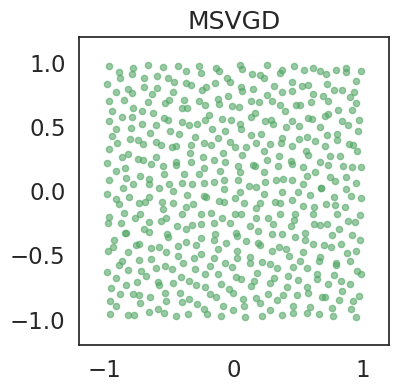

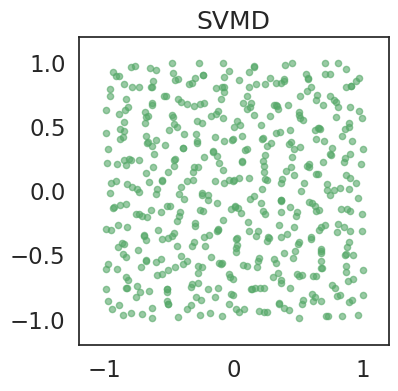

In [10]:
for method in methods:
    f, ax = plt.subplots(1, 1, figsize=(4, 4))
    samples_np = samples_dict[method].numpy()
    ax.scatter(samples_np[:, 0], samples_np[:, 1], alpha=.6, c="g", s=20)
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_title(name_map[method])